In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 33.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import re
from datasets import Dataset
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from google.colab import drive
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Load IMDB data
df = load_dataset("stanfordnlp/imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 8.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
train_data = df["train"]
test_data = df["test"]
train_df = pd.DataFrame(df["train"])
test_df = pd.DataFrame(df["test"])

In [ ]:
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=42)
test_df , _= train_test_split(test_df, test_size=0.8, random_state=42)

In [ ]:
#defined pre-processing function
def preprocess(text):
  text = text.lower() #lowercase text
  text = re.sub('<br />', ' ', text) #remove HTML tags and replace with space
  text = re.sub(r'http\S+', '', text) #remove web urls and replace them with space
  text = re.sub(r'\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text) #remove email ids
  return text #return pre-processed text

In [ ]:
x_train = [preprocess(text) for text in train_df['text']] #pre-processed reviews required for train
x_val = [preprocess(text) for text in val_df['text']] #pre-processed reviews required for validation
x_test = [preprocess(text) for text in test_df['text']] #pre-process reviews required for testing

In [ ]:
# Target variables for train, validation and test data respectively
y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

In [ ]:
#created dataset which would be required to create dataloader
train_dataset = Dataset.from_dict({"text": x_train, "label": y_train})
val_dataset = Dataset.from_dict({"text": x_val, "label": y_val})
test_dataset = Dataset.from_dict({"text": x_test, "label": y_test})

In [ ]:
#defined device as GPU for training model for fast computation
device = torch.device('cuda')

In [ ]:
# loaded pre-trained model Bert
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") # load pre-trained tokenizer from Bert
bert_model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2) #load Bert Model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize review data using bert tokenizer
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
#mount the drive which will be required to save best model
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
best_model_dir = "/content/drive/MyDrive/NLP_Coursework/bert_model_final2" #created the folder in drive on specified folder
# called 'bert_model_final2' where best trained Bert model will be saved

In [ ]:
#defined hyperparameter for training the model in Training Arguments
training_arguments = TrainingArguments(
    output_dir=best_model_dir,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",

)

In [ ]:
#defined performance function to get the accuracy.
def performance(evaluation_pred):
    y_pred, y_true = evaluation_pred
    y_pred = np.argmax(y_pred, axis=1)
    accuracy = (y_pred == y_true).mean()
    return {"accuracy": accuracy}

# defined trainer
imdb_trainer = Trainer(
    bert_model=bert_model.to(device),
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=performance,
)


In [ ]:
# Train the model
imdb_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.440500,0.210402,0.930000
2,0.176900,0.281106,0.933000
3,0.000700,0.331721,0.939800


TrainOutput(global_step=7500, training_loss=0.20008405642937868, metrics={'train_runtime': 3521.5864, 'train_samples_per_second': 17.038, 'train_steps_per_second': 2.13, 'total_flos': 1.57866633216e+16, 'train_loss': 0.20008405642937868, 'epoch': 3.0})

In [ ]:
imdb_trainer.save_model(best_model_dir) #save the best model in the directory mentioned above

In [ ]:
# Evaluate the model on the test set
test_performance = imdb_trainer.evaluate(test_dataset)
test_performance

{'eval_loss': 0.33002200722694397,
 'eval_accuracy': 0.941,
 'eval_runtime': 93.6895,
 'eval_samples_per_second': 53.368,
 'eval_steps_per_second': 13.342,
 'epoch': 3.0}

In [ ]:
bert_model_final = AutoModelForSequenceClassification.from_pretrained(best_model_dir) #load the best model from the path to do a quick test

In [ ]:
y_test = test_df['label']

In [ ]:
x_test= [preprocess(text) for text in test_df['text']]

In [ ]:
# test_dataset = Dataset.from_dict({"text": x_test, "label": y_test})

In [ ]:
# load bert tokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
bert_model_final = bert_model_final.to(device) #assign model to GPU

In [ ]:
example_text = "This is an example bad movie." #quick check on bert tokenizer on random small example

In [ ]:
tokenize_example = tokenizer(example_text ,truncation=True, padding=True, max_length=512, return_tensors="pt")

In [ ]:
tokenize_example # see tokenize text with its input_ids and attention mask

{'input_ids': tensor([[ 101, 2023, 2003, 2019, 2742, 2919, 3185, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
#using for loop to predict labels and store in a list
y_pred_test_list = []
for i in range(len(x_test)):
    tokenize_text = tokenizer(x_test[i], truncation=True, padding=True, max_length=512, return_tensors="pt")

    # assign tensors to GPU
    input_ids = tokenize_text['input_ids'].to(device)
    attention_mask = tokenize_text['attention_mask'].to(device)

    #make predictions
    y_pred_test = model(input_ids=input_ids, attention_mask=attention_mask)
    y_pred_test = y_pred_test.logits
    y_prob = torch.softmax(y_pred_test, dim=1)
    y_pred = torch.argmax(y_prob, dim=1).item()
    y_pred_test_list.append(y_pred)



In [ ]:
# Test performance of model by confusion matrix , Accuracy, F1 score and Precision

<Axes: >

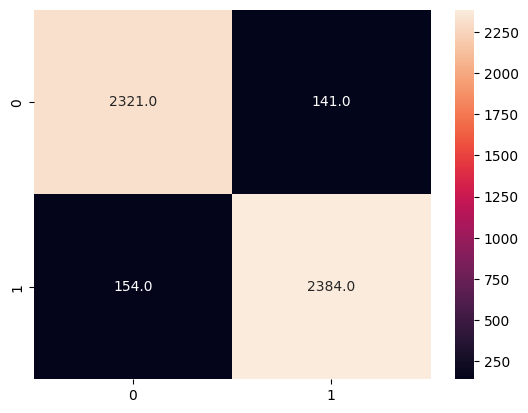

In [ ]:
sns.heatmap(confusion_matrix(test_df['label'],y_pred_test_list), annot=True, fmt= '.1f')

In [ ]:
print('Transformer Performance:')
print('Accuracy: ', accuracy_score(test_df['label'], y_pred_test_list))
print('Precision: ', precision_score(test_df['label'], y_pred_test_list))
print('F1_score: ', f1_score(test_df['label'], y_pred_test_list))

Transformer Performance:
Accuracy:  0.941
Precision:  0.9441584158415841
F1_score:  0.9417341497136085


In [ ]:
test_df['predicted_label']= y_pred_test_list # add predicted label to test_df dataframe which will used for error analysis

In [ ]:
test_df.head()

,text,label,predicted_label
23703,ý thýnk uzak ýs the one of the best films of a...,1,1
1717,This movie started out as a quite decent-looki...,0,0
2696,"As was mentioned before in other comments, the...",0,0
1848,Ghoulies IV starts in a museum storage facilit...,0,0
10623,I watched this as part of a vampire movie mara...,0,0


In [ ]:
#filtered misclassified classes and saved in error analysis dataframe
error_analysis_df =test_df[test_df['label']!=test_df['predicted_label']]


In [ ]:
error_analysis_df.head()

,text,label,predicted_label
721,If this movie were in production today it woul...,0,1
20703,Shame on you if you give this film a low ratin...,1,0
16732,This classic has so many great one-liners and ...,1,0
20283,i watch this film with horror in my heart beca...,1,0
16152,Based on the manga (comic) of well-known artis...,1,0


In [ ]:
# error_analysis_df.to_csv('error_analysis_Bert.csv') saved loacally to do error analysis